In [1]:
print('hello')

hello


<h3>this dataset is from https://www.kaggle.com/datasets/taranvee/smart-home-dataset-with-weather-information</h3>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import operator
import math
import random
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import cdist
from collections import defaultdict
from sklearn import datasets
from sklearn.datasets import make_blobs

# ignoring warnings
import warnings
warnings.simplefilter("ignore")
import os, cv2, json
np.random.seed(42)

In [3]:
#Load Dataset Iris
iris=datasets.load_iris()
iris

X = pd.DataFrame(iris.data,columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
y = pd.DataFrame(iris.target,columns=['Classes'])
X = X.values
y = y.values
data = X

# Mendefinisikan fungsi jarak euclidean
def euclidean_distance(point1,point2):
    dis=0
    for i in range(len(point1)):
        dis+=(point1[i]-point2[i])**2
    return dis**0.5

# utility values
m = 2
n = len(data)
c = 3
p = len(data[0])
max_iter = 100

# Initializing the Membership Matrix
def initialize_membership_matrix(n,c):
    member_mat=list()
    for i in range(n):
        random_list=[random.random() for x in range(c)]
        summation=sum(random_list)
        for i in range(len(random_list)):
            random_list[i]=random_list[i]/summation
        member_mat.append(random_list)
    return member_mat

def update_centroid(member_mat):
    centroids={}
    for j in range(c):
        temp=[]
        for k in range(p):      
            add=0
            for i in range(n):
                add+=member_mat[i][j]**m
            x=0
            for i in range(n):
                x+=(member_mat[i][j]**m)*(data[i][k])
            val=x/add
            temp.append(val)
        centroids[j]=temp
    return centroids

def update_membership_matrix(member_mat,centroids):
    ratio=float(2/(m-1))
    for i in range(n):
        distances=list()
        for j in range(c):
            distances.append(euclidean_distance(data[i],centroids[j]))
        for j in range(c):
            den = sum([math.pow(float(distances[j]/distances[q]), ratio) for q in range(c)])
            member_mat[i][j] = float(1/den)         
            
    return member_mat
        
def find_cluster(member_mat):
    clusters=list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(member_mat[i]))
        clusters.append(idx)
    return clusters

def check(old_member_mat,member_mat):
    diff=0
    for i in range(n):
        for j in range(c):
            diff+=old_member_mat[i][j]-member_mat[i][j]
    if(diff<0.01):
        return True
    return False

def fuzzy_c_mean():
    member_mat=initialize_membership_matrix(n,c)
    for i in range(max_iter):
        centroids=update_centroid(member_mat)
        old_member_mat=member_mat
        member_mat=update_membership_matrix(member_mat,centroids)
        cluster=find_cluster(member_mat)
        if(check(old_member_mat,member_mat))<0.01:
            print(i)
            break    
    
    return cluster,centroids

# Prediksi menggunakan FCM Clustering
clusters,centroids=fuzzy_c_mean()
print("Final Centroid points are:")
print(centroids)

# labeling the clusters
def label_clusters(clusters):
    z=0
    o=0
    t=0
    dict=defaultdict(int)

    for i in range(50):
        if(clusters[i]==0):
            z=z+1
        elif(clusters[i]==1):
            o=o+1
        else:
            t=t+1
    dict[z]=0
    dict[o]=1
    dict[t]=2
    classes=[]
    fin1=max(z,max(o,t))
    
    classes.append(dict[fin1])
    z=0
    o=0
    t=0
    for i in range(50,100):
        if(clusters[i]==0):
            z=z+1
        elif(clusters[i]==1):
            o=o+1
        else:
            t=t+1
    dict[z]=0
    dict[o]=1
    dict[t]=2

    fin1=max(z,max(o,t))
    
    classes.append(dict[fin1])
    z=0
    o=0
    t=0
    for i in range(100,150):
        if(clusters[i]==0):
            z=z+1
        elif(clusters[i]==1):
            o=o+1
        else:
            t=t+1
    dict[z]=0
    dict[o]=1
    dict[t]=2
    fin1=max(z,max(o,t))
    classes.append(dict[fin1])
    
    return classes

classes=label_clusters(clusters)


Final Centroid points are:
{0: [np.float64(5.003965960611252), np.float64(3.414088858778309), np.float64(1.4828155326056145), np.float64(0.25354631747874196)], 1: [np.float64(6.775011223752626), np.float64(3.052382271043556), np.float64(5.646781781918661), np.float64(2.0535466585408657)], 2: [np.float64(5.888932360609777), np.float64(2.761069363204441), np.float64(4.363951643133038), np.float64(1.3973150407078863)]}


In [4]:
def confusion_matrix(clusters,classes,labels):
    c_matrix=[[0 for i in range(labels)] for j in range(labels)]
    m=0
    n=0
    q=0
    for i in range(50):
        if clusters[i]==classes[0]:
            m=m+1
        elif clusters[i]==classes[1]:
            n=n+1
        else:
            q=q+1
    c_matrix[0][0]=m
    c_matrix[0][1]=n
    c_matrix[0][2]=q
    m=0
    n=0
    q=0
    for i in range(50,100):
        if clusters[i]==classes[0]:
            m=m+1
        elif clusters[i]==classes[1]:
            n=n+1
        else:
            q=q+1
    c_matrix[1][0]=m
    c_matrix[1][1]=n
    c_matrix[1][2]=q
    m=0
    n=0
    q=0

    for i in range(100,150):
        if clusters[i]==classes[0]:
            m=m+1
        elif clusters[i]==classes[1]:
            n=n+1
        else:
            q=q+1
    c_matrix[2][0]=m
    c_matrix[2][1]=n
    c_matrix[2][2]=q
    
    return c_matrix

# Performance Metric
class Metrics:
    def __init__(self,confusion_m):
        self.confusion_m=confusion_m
        self.total=np.sum(confusion_m)
        self.diagonal=np.sum(np.diag(confusion_m))
    
    def accuracy(self):
        accuracy=(self.diagonal/self.total)
        return accuracy
    
    def recall(self):
        recall=np.diag(self.confusion_m)/np.sum(self.confusion_m,axis=1)
        recall=np.mean(recall)
        return recall
    
    def precision(self):
        precision=np.diag(self.confusion_m)/np.sum(self.confusion_m,axis=0)
        precision=np.mean(precision)
        return precision
    
    def f1_score(self,precision,recall):
        f1_score=(2*precision*recall)/(precision+recall)
        return f1_score

# Performance
matrix=confusion_matrix(clusters,classes,3)
performance=Metrics(matrix)

accuracy=performance.accuracy()
recall=performance.recall()
precision=performance.precision()
f1_score=performance.f1_score(precision,recall)

print('confusion matrix is:',end='\n')
print(np.array(matrix),end='\n')

print("Accuracy of the model is {}".format(accuracy*100))
print("Recall of the model is {}".format(recall*100))
print("Precision of the model is {}".format(precision*100))
print("F1-Score of the model is {}".format(f1_score*100))


confusion matrix is:
[[50  0  0]
 [ 0 47  3]
 [ 0 13 37]]
Accuracy of the model is 89.33333333333333
Recall of the model is 89.33333333333331
Precision of the model is 90.27777777777777
F1-Score of the model is 89.80307248169913


Custom HC time: 155.8665533065796
Sklearn HC time: 0.014562606811523438


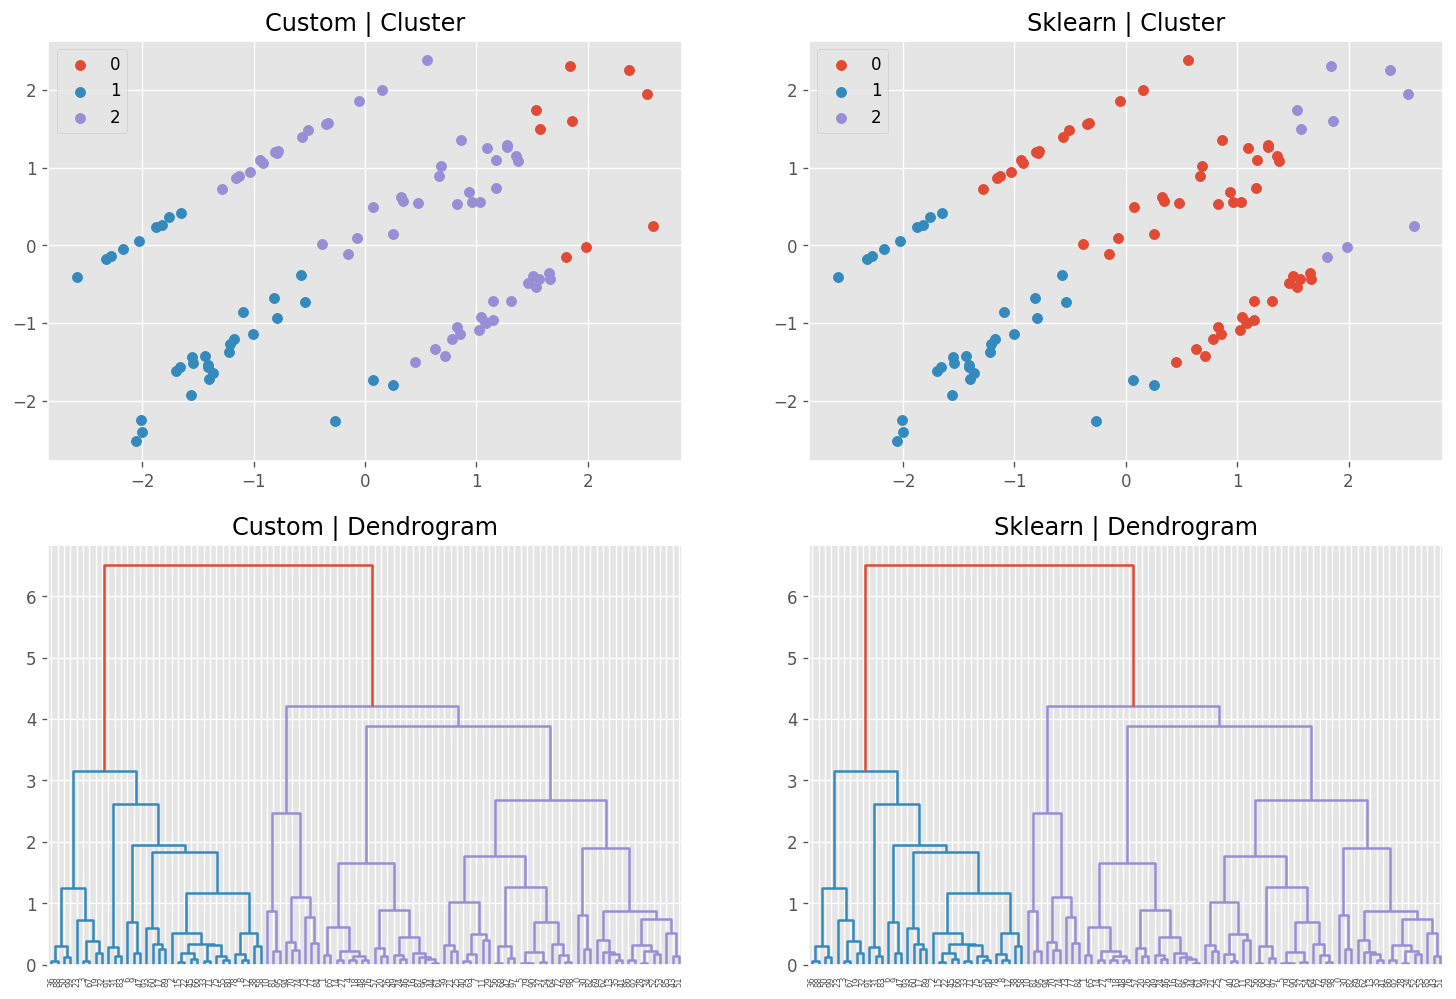

In [5]:
import time
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
plt.style.use('ggplot')

# Load Dataset
X, y = make_classification(100, n_features=2, n_redundant=0)

# Define Hierarchical Clustering Class
class HC:
    def __init__(self, verbose=False, linkage_type='complete'):
        self.verbose = verbose
        self.linkage_type = linkage_type
        
    def argmin(self, D):
        minx, miny = (0, 0)
        min_val = 10e5
        for i in range(D.shape[0]):
            for j in range(D.shape[0]):
                if j == i:
                    continue
                else:
                    if D[i, j] < min_val:
                        min_val = D[i, j]
                        minx = i
                        miny = j
                        
        return min_val, minx, miny
        
    def cluster_distance(self, cluster_members):
        nClusters = len(cluster_members)
        keys = list(cluster_members.keys())
        Distance = np.zeros((nClusters, nClusters))
        for i in range(nClusters):
            ith_elems = cluster_members[keys[i]]
            for j in range(nClusters):
                jth_elems = cluster_members[keys[j]]
                d_in_clusters = euclidean_distances(X[ith_elems], X[jth_elems])
                dij = np.max(d_in_clusters) if self.linkage_type == 'complete' else np.min(d_in_clusters)
                Distance[i, j] = dij

        return Distance
    
    def fit(self, X):
        self.nSamples = X.shape[0]
        cluster_members = dict([(i, [i]) for i in range(self.nSamples)])
        Z = np.zeros((self.nSamples - 1, 4))
        
        for i in range(self.nSamples - 1):
            if self.verbose:
                print(f'\n-------\nDebug Line at, i={i}\n--------')
            
            D = self.cluster_distance(cluster_members)
            _, tmpx, tmpy = self.argmin(D)
            
            x = list(cluster_members.keys())[tmpx]
            y = list(cluster_members.keys())[tmpy]
            Z[i, 0] = x
            Z[i, 1] = y
            Z[i, 2] = D[tmpx, tmpy]
            Z[i, 3] = len(cluster_members[x]) + len(cluster_members[y])
            
            cluster_members[i + self.nSamples] = cluster_members[x] + cluster_members[y]
            del cluster_members[x]
            del cluster_members[y]
            
        self.Z = Z
        return self.Z
    
    def predict(self, n_cluster=3):
        labels = np.zeros(self.nSamples)
        cluster_members = dict([(i, [i]) for i in range(self.nSamples)])
        
        for i in range(self.nSamples - n_cluster):
            x, y = self.Z[i, 0], self.Z[i, 1]
            cluster_members[self.nSamples + i] = cluster_members[x] + cluster_members[y]
            del cluster_members[x]
            del cluster_members[y]
            
        keys = list(cluster_members.keys())
        for i in range(len(keys)):
            samples_in_cluster = cluster_members[keys[i]]
            labels[samples_in_cluster] = i
            
        return labels

# Train Custom Hierarchical Clustering
start_time = time.time()
hc = HC(linkage_type='complete')
Z = hc.fit(X)
myLabel = hc.predict(n_cluster=3)
print("Custom HC time:", time.time() - start_time)

# Train Sklearn's Hierarchical Clustering
start_time = time.time()
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(X)
skLabel = clustering.labels_
print("Sklearn HC time:", time.time() - start_time)

# Visualization
fig, ax = plt.subplots(2, 2, facecolor='white', figsize=(15, 5 * 2), dpi=120)

for i in range(3):
    myIndices = myLabel == i
    skIndices = skLabel == i
    ax[0, 0].scatter(X[myIndices, 0], X[myIndices, 1], label=i)
    ax[0, 1].scatter(X[skIndices, 0], X[skIndices, 1], label=i)
    
ax[0, 0].set_title('Custom | Cluster')
ax[0, 1].set_title('Sklearn | Cluster')
ax[0, 0].legend()
ax[0, 1].legend()

z = hierarchy.linkage(X, 'complete')
hierarchy.dendrogram(Z, ax=ax[1, 0])
hierarchy.dendrogram(z, ax=ax[1, 1])

ax[1, 0].set_title('Custom | Dendrogram')
ax[1, 1].set_title('Sklearn | Dendrogram')
plt.show()


In [6]:
df = pd.read_csv("C:/Users/Thinkpad/Documents/ml_prak/Tugas_Mlprak_tm10/HomeC.csv")
print(df.head())

         time  use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  \
0  1451624400  0.932833  0.003483            0.932833         0.000033   
1  1451624401  0.934333  0.003467            0.934333         0.000000   
2  1451624402  0.931817  0.003467            0.931817         0.000017   
3  1451624403  1.022050  0.003483            1.022050         0.000017   
4  1451624404  1.139400  0.003467            1.139400         0.000133   

   Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  Fridge [kW]  \
0        0.020700        0.061917          0.442633     0.124150   
1        0.020717        0.063817          0.444067     0.124000   
2        0.020700        0.062317          0.446067     0.123533   
3        0.106900        0.068517          0.446583     0.123133   
4        0.236933        0.063983          0.446533     0.122850   

   Wine cellar [kW]  ...  visibility  summary  apparentTemperature  pressure  \
0          0.006983  ...        10.0    Clear                29.26

In [7]:
# Check how many NaN values each column has
print(df.isna().sum())

time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64


In [8]:
df.dropna(inplace=True)

In [9]:
# Check how many NaN values each column has
print(df.isna().sum())

time                   0
use [kW]               0
gen [kW]               0
House overall [kW]     0
Dishwasher [kW]        0
Furnace 1 [kW]         0
Furnace 2 [kW]         0
Home office [kW]       0
Fridge [kW]            0
Wine cellar [kW]       0
Garage door [kW]       0
Kitchen 12 [kW]        0
Kitchen 14 [kW]        0
Kitchen 38 [kW]        0
Barn [kW]              0
Well [kW]              0
Microwave [kW]         0
Living room [kW]       0
Solar [kW]             0
temperature            0
icon                   0
humidity               0
visibility             0
summary                0
apparentTemperature    0
pressure               0
windSpeed              0
cloudCover             0
windBearing            0
precipIntensity        0
dewPoint               0
precipProbability      0
dtype: int64


In [10]:
print("Duplikasi: ", df.duplicated().sum())

Duplikasi:  0


In [11]:
df.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503910 entries, 0 to 503909
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503910 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]            5

Converged after 0 iterations.
Final Centroid points are:
{0: [np.float64(-0.014329548178978744), np.float64(-0.003114965500962997), np.float64(-0.015001274717276764), np.float64(0.005052722910389015), np.float64(0.008445392862215267), np.float64(5.334735321167067)], 1: [np.float64(0.004914079509185363), np.float64(0.007539059431082469), np.float64(0.007098351555194149), np.float64(-0.021754276588084098), np.float64(0.0012043397681899333), np.float64(5.343970172224788)], 2: [np.float64(0.0025893741122120792), np.float64(0.010673469698176655), np.float64(0.010867261305672254), np.float64(0.005744851386342143), np.float64(-0.010803896151750807), np.float64(5.300624742377648)]}
Cluster Labels based on Summary:
Cluster 0: Sunny Weather
Cluster 1: Cloudy
Cluster 2: Sunny Weather


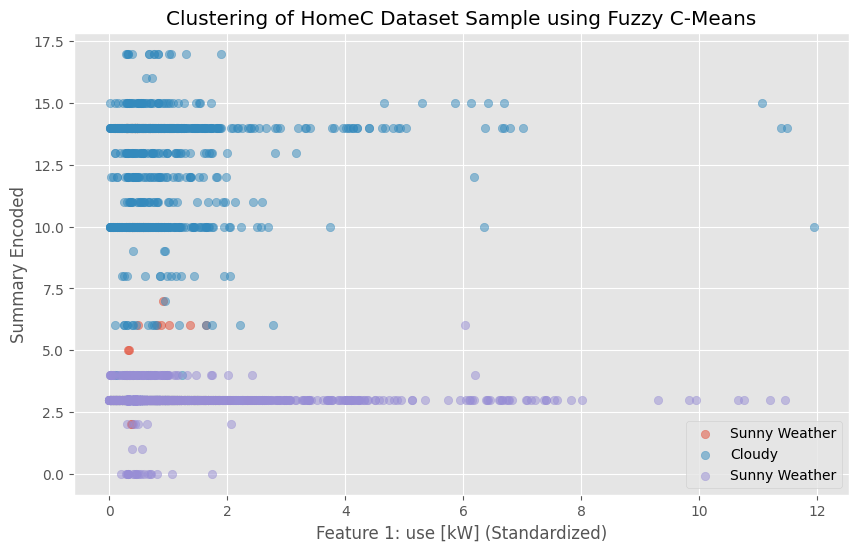

Confusion Matrix:
[[3664    5    0]
 [  12  695    0]
 [ 119  505    0]]
Accuracy: 87.18%
Precision: 79.00%
Recall: 87.18%
F1 Score: 82.32%
Mean Absolute Error: 0.15


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error
from collections import defaultdict, Counter
import warnings

# ignoring warnings
warnings.simplefilter("ignore")

# Load dataset
file_path = 'C:/Users/Thinkpad/Documents/ml_prak/Tugas_Mlprak_tm10/HomeC.csv'
home_data = pd.read_csv(file_path)

# Selecting a few representative numeric columns to reduce dimensionality
selected_features = ['use [kW]', 'temperature', 'humidity', 'pressure', 'windSpeed']
numeric_data_subset = home_data[selected_features].dropna()  # Drop rows with NaNs for simplicity

# Encoding the 'summary' column
# Dropping rows with NaNs from 'summary' as well to keep consistency with numeric features
home_data = home_data.dropna(subset=selected_features + ['summary'])
label_encoder = LabelEncoder()
home_data['summary_encoded'] = label_encoder.fit_transform(home_data['summary'])

# Adding the encoded 'summary' column to the dataset
numeric_data_subset = home_data[selected_features + ['summary_encoded', 'summary']]

# Taking a smaller sample of 5,000 rows to manage memory usage
numeric_data_sample = numeric_data_subset.sample(n=5000, random_state=42)

# Normalize the selected features (excluding the 'summary_encoded' for scaling)
scaler = StandardScaler()
data_normalized_sample = scaler.fit_transform(numeric_data_sample[selected_features])

# Add the 'summary_encoded' column back to the normalized data
data_normalized_sample = np.hstack((data_normalized_sample, numeric_data_sample[['summary_encoded']].values))

# Set up necessary variables for FCM clustering based on the sampled dataset
data = data_normalized_sample
n = len(data)
p = len(data[0])
c = 3  # Number of clusters to use
m = 2  # Fuzziness parameter
max_iter = 100

# Defining the Euclidean distance function
def euclidean_distance(point1, point2):
    dis = 0
    for i in range(len(point1)):
        dis += (point1[i] - point2[i]) ** 2
    return dis ** 0.5

# Initializing the Membership Matrix
def initialize_membership_matrix(n, c):
    member_mat = list()
    for i in range(n):
        random_list = [random.random() for _ in range(c)]
        summation = sum(random_list)
        for i in range(len(random_list)):
            random_list[i] = random_list[i] / summation
        member_mat.append(random_list)
    return member_mat

# Updating the Centroid
def update_centroid(member_mat):
    centroids = {}
    for j in range(c):
        temp = []
        for k in range(p):
            add = 0
            for i in range(n):
                add += member_mat[i][j] ** m
            x = 0
            for i in range(n):
                x += (member_mat[i][j] ** m) * (data[i][k])
            val = x / add
            temp.append(val)
        centroids[j] = temp
    return centroids

# Updating the Membership Matrix
def update_membership_matrix(member_mat, centroids):
    ratio = float(2 / (m - 1))
    for i in range(n):
        distances = list()
        for j in range(c):
            distances.append(euclidean_distance(data[i], centroids[j]))
        for j in range(c):
            den = sum([float(distances[j] / distances[q]) ** ratio for q in range(c)])
            member_mat[i][j] = float(1 / den)
    return member_mat

# Finding the Cluster
def find_cluster(member_mat):
    clusters = list()
    for i in range(n):
        _, idx = max((val, idx) for (idx, val) in enumerate(member_mat[i]))
        clusters.append(idx)
    return clusters

# Checking convergence condition
def check(old_member_mat, member_mat):
    diff = 0
    for i in range(n):
        for j in range(c):
            diff += abs(old_member_mat[i][j] - member_mat[i][j])
    if diff < 0.01:
        return True
    return False

# Fuzzy C-Means clustering
def fuzzy_c_mean():
    member_mat = initialize_membership_matrix(n, c)
    for i in range(max_iter):
        centroids = update_centroid(member_mat)
        old_member_mat = member_mat.copy()
        member_mat = update_membership_matrix(member_mat, centroids)
        cluster = find_cluster(member_mat)
        if check(old_member_mat, member_mat):
            print(f'Converged after {i} iterations.')
            break
    return cluster, centroids

# Predict using Fuzzy C-Means Clustering
clusters, centroids = fuzzy_c_mean()

# Displaying the final centroid points
print("Final Centroid points are:")
print(centroids)

# Add cluster labels to the sampled data
numeric_data_sample['cluster'] = clusters

# Post-process clusters to determine weather type label for each cluster
cluster_weather_labels = {}
for cluster_id in range(c):
    cluster_summaries = numeric_data_sample[numeric_data_sample['cluster'] == cluster_id]['summary']
    most_common_summary = Counter(cluster_summaries).most_common(1)[0][0]
    if 'clear' in most_common_summary.lower() or 'sun' in most_common_summary.lower():
        cluster_weather_labels[cluster_id] = 'Sunny Weather'
    elif 'cloud' in most_common_summary.lower():
        cluster_weather_labels[cluster_id] = 'Cloudy'
    else:
        cluster_weather_labels[cluster_id] = 'Others'

# Assigning the labels to the clusters
numeric_data_sample['weather_label'] = numeric_data_sample['cluster'].map(cluster_weather_labels)

# Printing out cluster labeling result
print("Cluster Labels based on Summary:")
for cluster_id, label in cluster_weather_labels.items():
    print(f"Cluster {cluster_id}: {label}")

# Scatter plot for first feature against 'summary_encoded' with clustering labels
plt.figure(figsize=(10, 6))
for cluster_id in range(c):
    cluster_data = numeric_data_sample[numeric_data_sample['cluster'] == cluster_id]
    plt.scatter(cluster_data['use [kW]'], cluster_data['summary_encoded'], label=cluster_weather_labels[cluster_id], alpha=0.5)

plt.title('Clustering of HomeC Dataset Sample using Fuzzy C-Means')
plt.xlabel('Feature 1: use [kW] (Standardized)')
plt.ylabel('Summary Encoded')
plt.legend()
plt.show()

# Evaluation Metrics
# Mapping the clusters to their respective dominant weather type
numeric_data_sample['predicted_label'] = numeric_data_sample['cluster'].map(cluster_weather_labels)
numeric_data_sample['true_label'] = numeric_data_sample['summary'].apply(lambda x: 'Sunny Weather' if 'clear' in x.lower() or 'sun' in x.lower() else ('Cloudy' if 'cloud' in x.lower() else 'Others'))

# Encoding true and predicted labels numerically for evaluation
label_mapping = {'Sunny Weather': 0, 'Cloudy': 1, 'Others': 2}
numeric_data_sample['predicted_label_encoded'] = numeric_data_sample['predicted_label'].map(label_mapping)
numeric_data_sample['true_label_encoded'] = numeric_data_sample['true_label'].map(label_mapping)

# Extracting true and predicted labels
y_true = numeric_data_sample['true_label_encoded']
y_pred = numeric_data_sample['predicted_label_encoded']

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculating accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculating precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculating Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred)

# Displaying the evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f}")


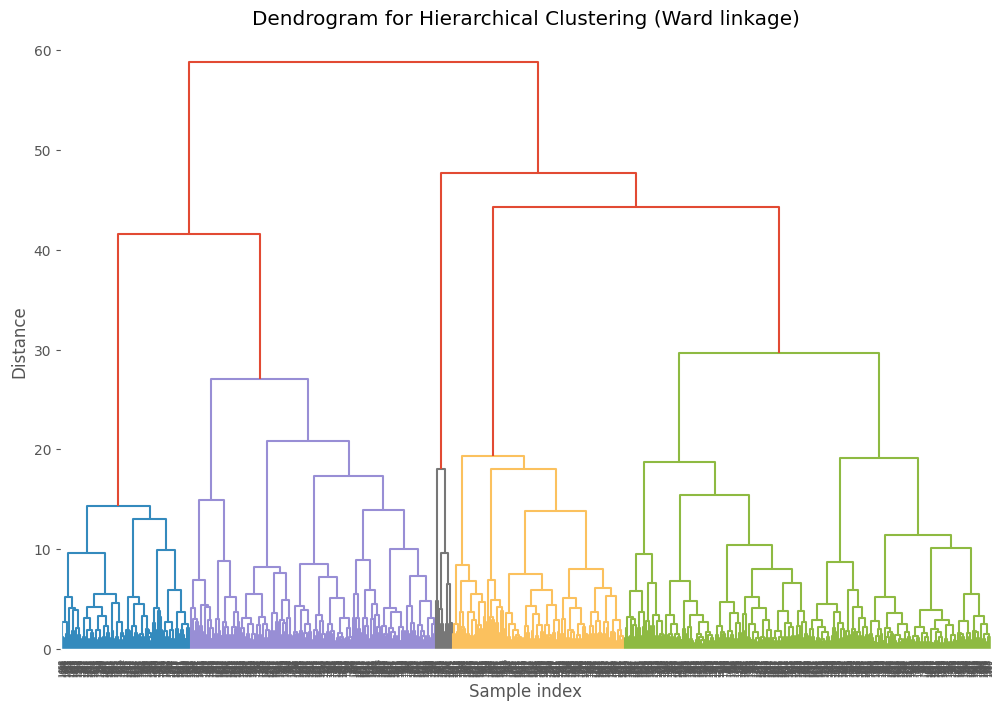

Hierarchical Clustering (Ward) time: 0.14361929893493652
Gaussian Mixture Model Clustering time: 0.5696849822998047
GMM Cluster Labels based on Summary:
Cluster 0: Sunny Weather
Cluster 1: Sunny Weather
Cluster 2: Sunny Weather


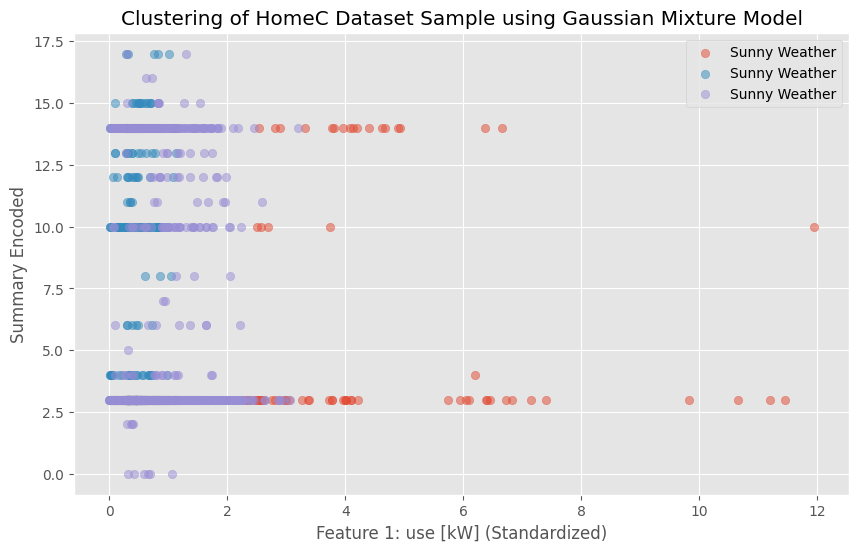

Confusion Matrix:
[[1438    0    0]
 [ 300    0    0]
 [ 262    0    0]]
Accuracy: 71.90%
Precision: 51.70%
Recall: 71.90%
F1 Score: 60.15%
Mean Absolute Error: 0.41


In [14]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error
from collections import Counter
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
import warnings

# Ignoring warnings
warnings.simplefilter("ignore")

# Load dataset
file_path = 'C:/Users/Thinkpad/Documents/ml_prak/Tugas_Mlprak_tm10/HomeC.csv'
home_data = pd.read_csv(file_path)

# Selecting a few representative numeric columns to reduce dimensionality
selected_features = ['use [kW]', 'temperature', 'humidity', 'pressure', 'windSpeed']
numeric_data_subset = home_data[selected_features].dropna()  # Drop rows with NaNs for simplicity

# Encoding the 'summary' column
home_data = home_data.dropna(subset=selected_features + ['summary'])
label_encoder = LabelEncoder()
home_data['summary_encoded'] = label_encoder.fit_transform(home_data['summary'])

# Adding the encoded 'summary' column to the dataset
numeric_data_subset = home_data[selected_features + ['summary_encoded', 'summary']]

# Taking a larger sample of 2000 rows to improve clustering and capture more patterns
numeric_data_sample = numeric_data_subset.sample(n=2000, random_state=42)

# Normalize the selected features (excluding the 'summary_encoded' for scaling)
scaler = StandardScaler()
data_normalized_sample = scaler.fit_transform(numeric_data_sample[selected_features])

# Apply PCA for dimensionality reduction - Adjusted to maintain 95% of the variance
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_normalized_sample)

# Calculate pairwise distances for Dendrogram
pairwise_distances = pdist(data_pca, metric='euclidean')

# Plotting the dendrogram
plt.figure(figsize=(12, 8))
linkage_matrix = hierarchy.linkage(pairwise_distances, method='ward')
hierarchy.dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering (Ward linkage)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Train Sklearn's Hierarchical Clustering (using 'ward' linkage)
start_time = time.time()
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(data_pca)
hc_labels = clustering.labels_
print("Hierarchical Clustering (Ward) time:", time.time() - start_time)

# Train Gaussian Mixture Model (GMM) Clustering
start_time = time.time()
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42).fit(data_pca)
gmm_labels = gmm.predict(data_pca)
print("Gaussian Mixture Model Clustering time:", time.time() - start_time)

# Assign labels for both Hierarchical and GMM clustering
numeric_data_sample['hc_cluster'] = hc_labels
numeric_data_sample['gmm_cluster'] = gmm_labels

# Post-process clusters to determine weather type label for each cluster for GMM
cluster_weather_labels_gmm = {}
for cluster_id in range(3):
    cluster_summaries = numeric_data_sample[numeric_data_sample['gmm_cluster'] == cluster_id]['summary']
    if len(cluster_summaries) > 0:
        most_common_summary = Counter(cluster_summaries).most_common(1)[0][0]
        if 'clear' in most_common_summary.lower() or 'sun' in most_common_summary.lower():
            cluster_weather_labels_gmm[cluster_id] = 'Sunny Weather'
        elif 'cloud' in most_common_summary.lower():
            cluster_weather_labels_gmm[cluster_id] = 'Cloudy'
        else:
            cluster_weather_labels_gmm[cluster_id] = 'Others'
    else:
        cluster_weather_labels_gmm[cluster_id] = 'Others'  # Default if cluster is empty

# Assign the labels to the GMM clusters
numeric_data_sample['predicted_label'] = numeric_data_sample['gmm_cluster'].map(cluster_weather_labels_gmm)

# Printing out cluster labeling result
print("GMM Cluster Labels based on Summary:")
for cluster_id, label in cluster_weather_labels_gmm.items():
    print(f"Cluster {cluster_id}: {label}")

# Scatter plot for GMM clustering with the predicted labels
plt.figure(figsize=(10, 6))
for cluster_id in range(3):
    cluster_data = numeric_data_sample[numeric_data_sample['gmm_cluster'] == cluster_id]
    plt.scatter(cluster_data['use [kW]'], cluster_data['summary_encoded'], label=cluster_weather_labels_gmm[cluster_id], alpha=0.5)

plt.title('Clustering of HomeC Dataset Sample using Gaussian Mixture Model')
plt.xlabel('Feature 1: use [kW] (Standardized)')
plt.ylabel('Summary Encoded')
plt.legend()
plt.show()

# Evaluation Metrics for GMM Clustering
numeric_data_sample['true_label'] = numeric_data_sample['summary'].apply(
    lambda x: 'Sunny Weather' if 'clear' in x.lower() or 'sun' in x.lower() else ('Cloudy' if 'cloud' in x.lower() else 'Others')
)

# Encoding true and predicted labels numerically for evaluation
label_mapping = {'Sunny Weather': 0, 'Cloudy': 1, 'Others': 2}
numeric_data_sample['predicted_label_encoded'] = numeric_data_sample['predicted_label'].map(label_mapping)
numeric_data_sample['true_label_encoded'] = numeric_data_sample['true_label'].map(label_mapping)

# Extracting true and predicted labels
y_true = numeric_data_sample['true_label_encoded']
y_pred = numeric_data_sample['predicted_label_encoded']

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculating accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculating precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculating Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred)

# Displaying the evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f}")

Iteration 10/199 completed.
Iteration 20/199 completed.
Iteration 30/199 completed.
Iteration 40/199 completed.
Iteration 50/199 completed.
Iteration 60/199 completed.
Iteration 70/199 completed.
Iteration 80/199 completed.
Iteration 90/199 completed.
Iteration 100/199 completed.
Iteration 110/199 completed.
Iteration 120/199 completed.
Iteration 130/199 completed.
Iteration 140/199 completed.
Iteration 150/199 completed.
Iteration 160/199 completed.
Iteration 170/199 completed.
Iteration 180/199 completed.
Iteration 190/199 completed.
Iteration 199/199 completed.

Custom Hierarchical Clustering time: 6.24 seconds

----- Custom Hierarchical Clustering Evaluation -----
Confusion Matrix:
[[138   2   0]
 [ 35   2   0]
 [ 23   0   0]]
Accuracy: 70.00%
Precision: 58.54%
Recall: 70.00%
F1 Score: 59.30%
Mean Absolute Error: 0.41


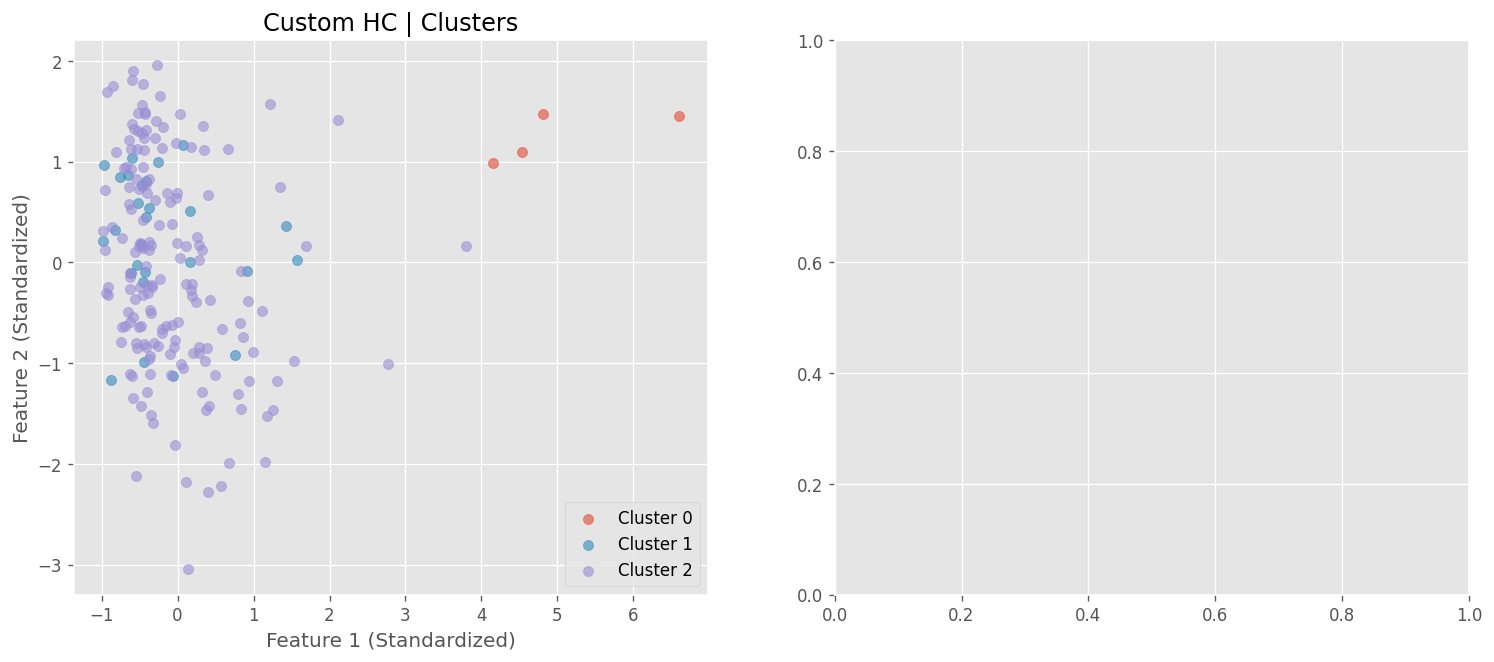

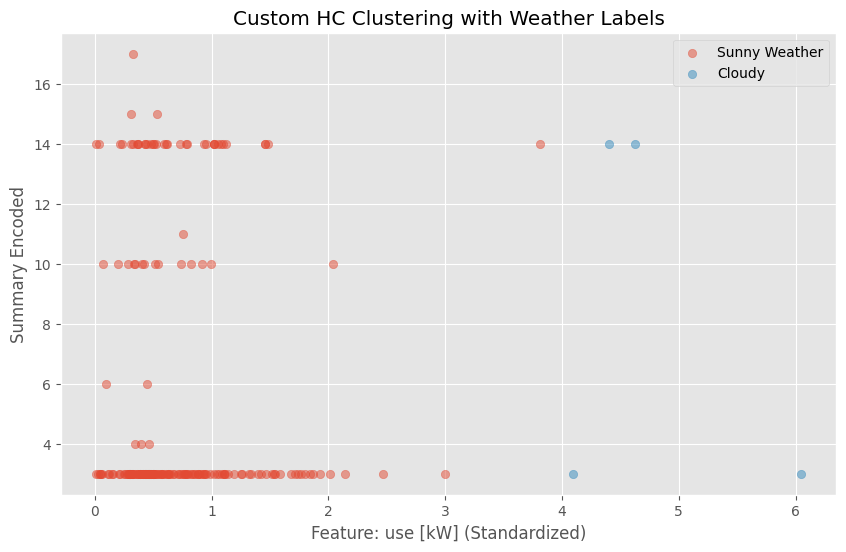

In [21]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
import warnings

# Set plot style
plt.style.use('ggplot')

# Ignore warnings
warnings.simplefilter("ignore")

# ----------------------------
# Data Loading and Preprocessing
# ----------------------------

# Load dataset
file_path = 'C:/Users/Thinkpad/Documents/ml_prak/Tugas_Mlprak_tm10/HomeC.csv'
home_data = pd.read_csv(file_path)

# Selecting representative numeric columns to reduce dimensionality
selected_features = ['use [kW]', 'temperature', 'humidity', 'pressure', 'windSpeed']
home_data = home_data.dropna(subset=selected_features + ['summary'])  # Ensure no NaNs in selected features and 'summary'

# Encoding the 'summary' column
label_encoder = LabelEncoder()
home_data['summary_encoded'] = label_encoder.fit_transform(home_data['summary'])

# Selecting the necessary columns
numeric_data_subset = home_data[selected_features + ['summary_encoded', 'summary']]

# Taking a smaller sample (e.g., 200 samples) to manage computation time for custom HC
# Adjust the sample size as needed based on your system's capabilities
numeric_data_sample = numeric_data_subset.sample(n=200, random_state=42).reset_index(drop=True)

# Normalize the selected features (excluding the 'summary_encoded' for scaling)
scaler = StandardScaler()
data_normalized_sample = scaler.fit_transform(numeric_data_sample[selected_features])

# Define data and parameters for clustering
X = data_normalized_sample  # Features for clustering
y_true = numeric_data_sample['summary_encoded'].values  # True labels

# Number of clusters
n_clusters = 3

# ----------------------------
# Optimized Hierarchical Clustering Class
# ----------------------------

class OptimizedHC:
    def __init__(self, linkage_type='complete'):
        """
        Initialize the Optimized Hierarchical Clustering class.

        Parameters:
        - linkage_type (str): The linkage criterion to use ('complete', 'single', 'average').
        """
        self.linkage_type = linkage_type
        self.Z = None  # To store the linkage matrix

    def fit(self, X):
        """
        Fit the hierarchical clustering model to the data.

        Parameters:
        - X (numpy.ndarray): The data matrix.

        Returns:
        - Z (numpy.ndarray): The linkage matrix.
        """
        self.nSamples = X.shape[0]
        # Initialize each sample as its own cluster
        cluster_members = {i: [i] for i in range(self.nSamples)}
        # Initialize the distance matrix
        D = euclidean_distances(X)
        np.fill_diagonal(D, np.inf)  # Avoid self-distance
        Z = np.zeros((self.nSamples - 1, 4))

        for i in range(self.nSamples - 1):
            # Find the two closest clusters
            idx = np.unravel_index(np.argmin(D), D.shape)
            x_idx, y_idx = idx
            current_clusters = sorted(cluster_members.keys())
            x_key = current_clusters[x_idx]
            y_key = current_clusters[y_idx]
            min_dist = D[x_idx, y_idx]

            # Update linkage matrix
            Z[i, 0] = x_key
            Z[i, 1] = y_key
            Z[i, 2] = min_dist
            Z[i, 3] = len(cluster_members[x_key]) + len(cluster_members[y_key])

            # Merge clusters x and y into new_cluster
            new_cluster = self.nSamples + i
            cluster_members[new_cluster] = cluster_members[x_key] + cluster_members[y_key]

            # Remove the old clusters
            del cluster_members[x_key]
            del cluster_members[y_key]

            # Update the distance matrix
            new_distances = []
            updated_clusters = sorted(cluster_members.keys())

            for j in updated_clusters:
                if j == new_cluster:
                    new_distances.append(np.inf)  # Distance to itself
                    continue
                members_j = cluster_members[j]
                members_new = cluster_members[new_cluster]
                distances = euclidean_distances(X[members_j], X[members_new])

                # Calculate the distance based on the linkage type
                if self.linkage_type == 'complete':
                    dist = np.max(distances)
                elif self.linkage_type == 'single':
                    dist = np.min(distances)
                else:  # 'average'
                    dist = np.mean(distances)
                new_distances.append(dist)

            # Remove old clusters from D
            D = np.delete(D, [x_idx, y_idx], axis=0)
            D = np.delete(D, [x_idx, y_idx], axis=1)

            # Add new cluster distances
            new_distances = np.array(new_distances)
            D = np.vstack((D, new_distances[:-1].reshape(1, -1)))
            D = np.hstack((D, new_distances.reshape(-1, 1)))

            # Optional: Print progress every 10 iterations
            if (i + 1) % 10 == 0 or i == self.nSamples - 2:
                print(f'Iteration {i+1}/{self.nSamples -1} completed.')

        self.Z = Z
        return self.Z

    def predict(self, n_cluster=3):
        """
        Predict cluster labels for the data.

        Parameters:
        - n_cluster (int): The desired number of clusters.

        Returns:
        - labels (numpy.ndarray): Cluster labels for each sample.
        """
        labels = np.zeros(self.nSamples, dtype=int)
        cluster_members = {i: [i] for i in range(self.nSamples)}

        for i in range(self.nSamples - n_cluster):
            x_key = int(self.Z[i, 0])
            y_key = int(self.Z[i, 1])
            new_key = self.nSamples + i
            cluster_members[new_key] = cluster_members[x_key] + cluster_members[y_key]
            del cluster_members[x_key]
            del cluster_members[y_key]

        # Assign cluster labels
        for cluster_label, members in enumerate(sorted(cluster_members.keys())):
            for sample_idx in cluster_members[members]:
                labels[sample_idx] = cluster_label

        return labels

# ----------------------------
# Custom Hierarchical Clustering
# ----------------------------

# Train Custom Hierarchical Clustering
start_time = time.time()
hc = OptimizedHC(linkage_type='complete')  # You can change linkage_type as needed
Z_custom = hc.fit(X)
myLabel = hc.predict(n_cluster=n_clusters)
custom_time = time.time() - start_time
print(f"\nCustom Hierarchical Clustering time: {custom_time:.2f} seconds")

# ----------------------------
# Visualization
# ----------------------------

fig, ax = plt.subplots(1, 2, facecolor='white', figsize=(15, 6), dpi=120)

# Plot Custom HC Clusters
for i in range(n_clusters):
    indices = myLabel == i
    ax[0].scatter(X[indices, 0], X[indices, 1], label=f'Cluster {i}', alpha=0.6)
ax[0].set_title('Custom HC | Clusters')
ax[0].set_xlabel('Feature 1 (Standardized)')
ax[0].set_ylabel('Feature 2 (Standardized)')
ax[0].legend()

# ----------------------------
# Evaluation Metrics
# ----------------------------

def map_clusters_to_labels(cluster_labels, cluster_num, data_frame, cluster_column):
    """
    Map each cluster to a weather label based on the most common summary in the cluster.

    Parameters:
    - cluster_labels (numpy.ndarray): Array of cluster labels.
    - cluster_num (int): Number of clusters.
    - data_frame (pandas.DataFrame): The DataFrame containing the data.
    - cluster_column (str): The column name for cluster assignments.

    Returns:
    - cluster_weather_labels (dict): Mapping from cluster ID to weather label.
    """
    cluster_weather_labels = {}
    for cluster_id in range(cluster_num):
        cluster_summaries = data_frame[data_frame[cluster_column] == cluster_id]['summary']
        if not cluster_summaries.empty:
            most_common_summary = Counter(cluster_summaries).most_common(1)[0][0]
            if 'clear' in most_common_summary.lower() or 'sun' in most_common_summary.lower():
                cluster_weather_labels[cluster_id] = 'Sunny Weather'
            elif 'cloud' in most_common_summary.lower():
                cluster_weather_labels[cluster_id] = 'Cloudy'
            else:
                cluster_weather_labels[cluster_id] = 'Others'
        else:
            cluster_weather_labels[cluster_id] = 'Unknown'  # Handle empty clusters
    return cluster_weather_labels

# Assign cluster labels for Custom HC
numeric_data_sample['custom_cluster'] = myLabel

# Assign cluster labels for Scikit-learn HC
numeric_data_sample['sklearn_cluster'] = skLabel

# Map clusters to weather labels for Custom HC
custom_cluster_labels = map_clusters_to_labels(myLabel, n_clusters, numeric_data_sample, 'custom_cluster')

# Map clusters to weather labels for Scikit-learn HC
sklearn_cluster_labels = map_clusters_to_labels(skLabel, n_clusters, numeric_data_sample, 'sklearn_cluster')

# Assign weather labels based on cluster assignments
numeric_data_sample['custom_weather_label'] = numeric_data_sample['custom_cluster'].map(custom_cluster_labels)
numeric_data_sample['sklearn_weather_label'] = numeric_data_sample['sklearn_cluster'].map(sklearn_cluster_labels)

# Define true labels
numeric_data_sample['true_label'] = numeric_data_sample['summary'].apply(
    lambda x: 'Sunny Weather' if 'clear' in x.lower() or 'sun' in x.lower() else (
        'Cloudy' if 'cloud' in x.lower() else 'Others')
)

# Encode labels numerically for evaluation
label_mapping = {'Sunny Weather': 0, 'Cloudy': 1, 'Others': 2, 'Unknown': -1}  # Include 'Unknown' if any
numeric_data_sample['custom_label_encoded'] = numeric_data_sample['custom_weather_label'].map(label_mapping)
numeric_data_sample['sklearn_label_encoded'] = numeric_data_sample['sklearn_weather_label'].map(label_mapping)
numeric_data_sample['true_label_encoded'] = numeric_data_sample['true_label'].map(label_mapping)

# Remove samples with 'Unknown' cluster assignments to avoid skewing evaluation metrics
filtered_data_custom = numeric_data_sample[numeric_data_sample['custom_label_encoded'] != -1].copy()
filtered_data_sklearn = numeric_data_sample[numeric_data_sample['sklearn_label_encoded'] != -1].copy()

# ----- Custom HC Evaluation -----
y_pred_custom = filtered_data_custom['custom_label_encoded']
y_true_custom = filtered_data_custom['true_label_encoded']

conf_matrix_custom = confusion_matrix(y_true_custom, y_pred_custom)
accuracy_custom = accuracy_score(y_true_custom, y_pred_custom)
precision_custom = precision_score(y_true_custom, y_pred_custom, average='weighted', zero_division=0)
recall_custom = recall_score(y_true_custom, y_pred_custom, average='weighted', zero_division=0)
f1_custom = f1_score(y_true_custom, y_pred_custom, average='weighted', zero_division=0)
mae_custom = mean_absolute_error(y_true_custom, y_pred_custom)

print("\n----- Custom Hierarchical Clustering Evaluation -----")
print("Confusion Matrix:")
print(conf_matrix_custom)
print(f"Accuracy: {accuracy_custom * 100:.2f}%")
print(f"Precision: {precision_custom * 100:.2f}%")
print(f"Recall: {recall_custom * 100:.2f}%")
print(f"F1 Score: {f1_custom * 100:.2f}%")
print(f"Mean Absolute Error: {mae_custom:.2f}")

# ----------------------------
# Additional Visualization (Optional)
# ----------------------------

# Scatter plot for Custom HC with Weather Labels
plt.figure(figsize=(10, 6))
for label in set(custom_cluster_labels.values()):
    if label != 'Unknown':  # Exclude 'Unknown' for clarity
        cluster_data = numeric_data_sample[numeric_data_sample['custom_weather_label'] == label]
        plt.scatter(cluster_data['use [kW]'], cluster_data['summary_encoded'], label=label, alpha=0.5)
plt.title('Custom HC Clustering with Weather Labels')
plt.xlabel('Feature: use [kW] (Standardized)')
plt.ylabel('Summary Encoded')
plt.legend()
plt.show()
